# ManyDepth
https://github.com/nianticlabs/manydepth

In [50]:
import os
import sys
import json
import argparse
import numpy as np
import PIL.Image as pil
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import pyplot as plt

import torch
from torchvision import transforms

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from manydepth import networks
from layers import transformation_from_parameters

### Utility Functions

In [8]:
def load_and_preprocess_image(image_path, resize_width, resize_height):
    image = pil.open(image_path).convert('RGB')
    original_width, original_height = image.size
    image = image.resize((resize_width, resize_height), pil.LANCZOS)
    image = transforms.ToTensor()(image).unsqueeze(0)
    if torch.cuda.is_available():
        return image.cuda(), (original_height, original_width)
    return image, (original_height, original_width)

In [9]:
def load_and_preprocess_intrinsics(intrinsics_path, resize_width, resize_height):
    K = np.eye(4)
    with open(intrinsics_path, 'r') as f:
        K[:3, :3] = np.array(json.load(f))

    # Convert normalised intrinsics to 1/4 size unnormalised intrinsics.
    # (The cost volume construction expects the intrinsics corresponding to 1/4 size images)
    K[0, :] *= resize_width // 4
    K[1, :] *= resize_height // 4

    invK = torch.Tensor(np.linalg.pinv(K)).unsqueeze(0)
    K = torch.Tensor(K).unsqueeze(0)

    if torch.cuda.is_available():
        return K.cuda(), invK.cuda()
    return K, invK

### Configuration

In [24]:
target_image_path = '../assets/test_sequence_target.jpg'
source_image_path = '../assets/test_sequence_source.jpg'

model_path = '../models/city_scapes'
intrinsics_json_path = '../assets/test_sequence_intrinsics.json'

mode = 'multi' # mono/multi

### Loading pretrained Model

In [21]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("-> Loading model from ", model_path)

print("   Loading pretrained encoder")
encoder_dict = torch.load(os.path.join(model_path, "encoder.pth"), map_location=device)
encoder = networks.ResnetEncoderMatching(18, False,
                                         input_width=encoder_dict['width'],
                                         input_height=encoder_dict['height'],
                                         adaptive_bins=True,
                                         min_depth_bin=encoder_dict['min_depth_bin'],
                                         max_depth_bin=encoder_dict['max_depth_bin'],
                                         depth_binning='linear',
                                         num_depth_bins=96)

filtered_dict_enc = {k: v for k, v in encoder_dict.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

print("   Loading pretrained decoder")
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict = torch.load(os.path.join(model_path, "depth.pth"), map_location=device)
depth_decoder.load_state_dict(loaded_dict)

print("   Loading pose network")
pose_enc_dict = torch.load(os.path.join(model_path, "pose_encoder.pth"),
                           map_location=device)
pose_dec_dict = torch.load(os.path.join(model_path, "pose.pth"), map_location=device)

pose_enc = networks.ResnetEncoder(18, False, num_input_images=2)
pose_dec = networks.PoseDecoder(pose_enc.num_ch_enc, num_input_features=1,
                                num_frames_to_predict_for=2)

pose_enc.load_state_dict(pose_enc_dict, strict=True)
pose_dec.load_state_dict(pose_dec_dict, strict=True)

# Setting states of networks
encoder.eval()
depth_decoder.eval()
pose_enc.eval()
pose_dec.eval()
if torch.cuda.is_available():
    encoder.cuda()
    depth_decoder.cuda()
    pose_enc.cuda()
    pose_dec.cuda()

-> Loading model from  ../models/city_scapes
   Loading pretrained encoder
   Loading pretrained decoder
   Loading pose network


### Load input data

In [25]:
# Load input data
input_image, original_size = load_and_preprocess_image(target_image_path,
                                                    resize_width=encoder_dict['width'],
                                                    resize_height=encoder_dict['height'])

source_image, _ = load_and_preprocess_image(source_image_path,
                                            resize_width=encoder_dict['width'],
                                            resize_height=encoder_dict['height'])

K, invK = load_and_preprocess_intrinsics(intrinsics_json_path,
                                        resize_width=encoder_dict['width'],
                                        resize_height=encoder_dict['height'])

### Inference

In [27]:
with torch.no_grad():

    # Estimate poses
    pose_inputs = [source_image, input_image]
    pose_inputs = [pose_enc(torch.cat(pose_inputs, 1))]
    axisangle, translation = pose_dec(pose_inputs)
    pose = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=True)

    if mode == 'mono':
        pose *= 0  # zero poses are a signal to the encoder not to construct a cost volume
        source_image *= 0

    # Estimate depth
    output, lowest_cost, _ = encoder(current_image=input_image,
                                    lookup_images=source_image.unsqueeze(1),
                                    poses=pose.unsqueeze(1),
                                    K=K,
                                    invK=invK,
                                    min_depth_bin=encoder_dict['min_depth_bin'],
                                    max_depth_bin=encoder_dict['max_depth_bin'])

    output = depth_decoder(output)

    sigmoid_output = output[("disp", 0)]
    sigmoid_output_resized = torch.nn.functional.interpolate(sigmoid_output, original_size, mode="bilinear", align_corners=False)
    sigmoid_output_resized = sigmoid_output_resized.cpu().numpy()[:, 0]
    


### Analyse images

DEPTH MAP
shape: (315, 895)
min: 0.035322648
max: 0.63369685


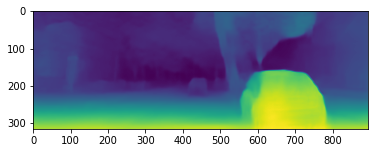


RGB IMAGE
shape: (192, 512, 3)
min: 0.0
max: 1.0


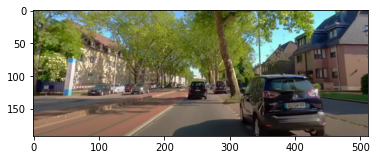

In [53]:
depth = sigmoid_output_resized[0]

img = input_image.numpy()[0,...]
img = np.moveaxis(img, 0, -1)

print('DEPTH MAP')
print('shape:', depth.shape)
print('min:', np.amin(depth))
print('max:', np.amax(depth))
plt.imshow(depth)
plt.show()

print('\nRGB IMAGE')
print('shape:', img.shape)
print('min:', np.amin(img))
print('max:', np.amax(img))
plt.imshow(img)
plt.show()

**bold text**